# GPH Construction with 

In [10]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import ipywidgets as widgets
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def bond_cash_flows(maturity, principal = 100, coupon_rate = .03, coupons_per_year = 12):
    """
    Returns a series of cash flows generated by a bond
    indexed by a coupon number
    """
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate / coupons_per_year
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data = coupon_amt, index = coupon_times)
    cash_flows.iloc[-1] += principal
    return cash_flows

def bond_price(maturity, principal=100, coupon_rate=.03, coupons_per_year=12, discount_rate=.03):
    """
    price a bond based on bond parameters maturity, principal, coupon rate and coupons per year
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)

In [12]:
erk.bond_cash_flows(3, 100, .03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [14]:
erk.bond_price(20, 1000, .05, 2, .04) #you pay a premium, because teh coupon rate is higher than today's interest rate

1136.7773962036904

In [15]:
rates = np.linspace(.01, .10, num = 20)

<AxesSubplot:title={'center':'Price of 10y bond with diff IR'}>

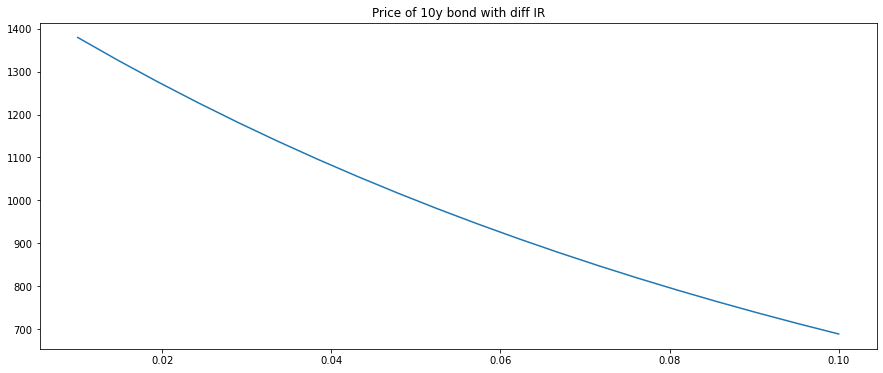

In [16]:
prices = [erk.bond_price(10, 1000, .05, 2, rate) for rate in rates]
pd.DataFrame(data = prices, index = rates).plot(title = 'Price of 10y bond with diff IR', legend = False, figsize = (15,6))

In [81]:
cf = erk.bond_cash_flows(3, 1000, .06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [96]:
discounts = erk.discount(cf.index, .06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [97]:
dcf = discounts*cf
dcf #the PRESENT value of each of the cash flows coming from the bond

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [98]:
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [101]:
(cf.index * weights).sum() 
# The weighted average duration for how long you have to wait to get your money back:
# macaulay duration

5.579707187194534

In [102]:
## the duration of the bond is directly linked to how much the price will change when interest rates change
#for a zero coupon bond, the weighted average duration = the maturity
# but for anythign that pays coupons before it's maturity, they will have a shorter macaulay duration

In [103]:
def macaulay_duration(flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows, given a per-period discount rate
    """
    discounted_flows = discount(flows.index, discount_rate)*pd.DataFrame(flows)
    weights = discounted_flows/discounted_flows.sum()
    return np.average(flows.index, weights=weights.iloc[:,0])

erk.macaulay_duration(erk.bond_cash_flows(3, 1000, .06, 2), .06/2)

5.579707187194534

In [106]:
#If you can match the macaulay duration of your bonds to the macaulay duration of your liabilities
#you get two portfolios that change IN THE SAME WAY wrt changes in interest rates
#so if you can match it, then as interest rates move, your bond portfolio will move in step with your liabilities
#This is true only for shifts of the yield curve, but a change in the shape of it will throw things off

# Duration Matching

In [108]:
liabilities = pd.Series(data = [100_000, 100_000], index = [10, 12])
erk.macaulay_duration(liabilities, .04)

10.960799385088393

In [109]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)

In [110]:
md_10, md_20

(8.190898824083233, 13.544718122145921)

we want to find the weights of how much we put in bond 1 vs in bond 2, in order to get the macaulay duration = 10.96

Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

```python
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective
    duration that matches cf_t
    """
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)
```

While we are at it, let's update the funding ratio we developed the last time to support cash flows in the assets:

```python
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return pv(assets, r)/pv(liabilities, r)
```


In [113]:
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, .04)
w_s

0.48263092069478974

In [120]:
p_short = erk.bond_price(10, 1000, .05, 1, .04)
p_long = erk.bond_price(20, 1000, .05, 1, .04)
a_0 = 130_000
p_flows = pd.concat([short_bond * (a_0 * w_s / p_short),long_bond * (a_0 * (1-w_s) / p_long) ])

erk.macaulay_duration(p_flows, .04)

10.960799385088393

In [124]:
cfr = erk.funding_ratio(p_flows, liabilities, .04)
cfr

0.9998760012192478

<AxesSubplot:title={'center':'Funding Ratios with changes in Interest Rates'}>

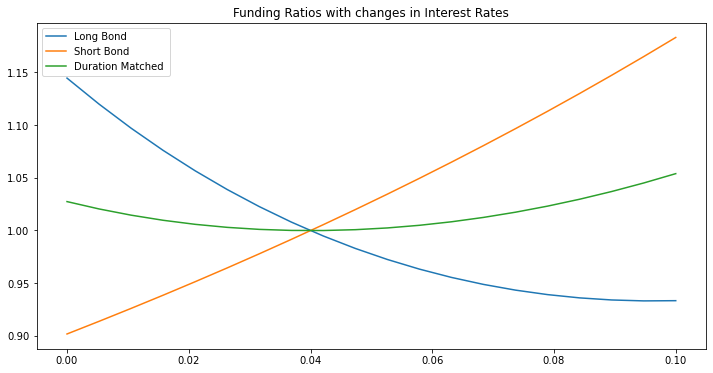

In [132]:
rates = np.linspace(0, .1, 20)
lb_assets = a_0*long_bond/p_long
sb_assets = a_0*short_bond/p_short


fr_change = pd.DataFrame({
    "Long Bond": [erk.funding_ratio(lb_assets, liabilities, rate) for rate in rates],
    "Short Bond": [erk.funding_ratio(sb_assets, liabilities, rate) for rate in rates],
    "Duration Matched ": [erk.funding_ratio(p_flows, liabilities, rate) for rate in rates]
}, index = rates)

fr_change.plot(title = 'Funding Ratios with changes in Interest Rates', figsize = (12,6))